# **Enunciado**

## José Daniel Sarmiento Blanco 2192232

### Ejemplo de proyecto de diseño


Requerimiento: Enfriar leche para almacenamiento.

1. Especificación cuantitativa de requerimiento:

    1.1 Requerimiento funcionales. 
        
        - $m_l=0.5Kg/s$ 
        - Enfriar desde 80 ºC hasta 10 ºC
        - Se dispone de $m_w=2.5kg/s$ agua proveniente de una torre a 24ºC.

    1.2 Requerimiento no funcionales.

        - Operable y seguro.
        - Costo mínimo.

2. Concepto de diseño:

    2.1 Solo enfriamiento con agua.

    2.2 Solo enfriamiento con un sistema de refrigeración.
    
    2.3 Sistema combinado.

        - Agua primero por SR.
        - Agua primero por pre-enfriador.


## Importar librerías necesarias

In [388]:
from pyfluids import Fluid, FluidsList, Input, Mixture
from core import ThermoFormules
import numpy as np
from pprint import pprint
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

## Establecer valores conocidos

In [389]:
caudal_leche                              = 0.5 # kg/s
temperatura_entrada_leche                 = 80 # ºC
temperatura_salida_leche                  = 10 # ºC

temperatura_entrada_agua                  = 24 # ºC

caudal_agua                               = 2.5 # kg/s

### Definición de salida temperatura

In [390]:
temperatura_estimada_salida_leche          = 45  # ºC

In [391]:
temperaturas_leche_estimada_salidas = np.arange(35, 55)
temperaturas_leche_estimada_salidas

array([35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

# - Diseño combinado

## 0. Establecer valores pre-diseño

In [392]:
k_material                            = 16.3    # W/ m * k Acero inoxidable
diametro_interior                     = 17e-3 # m
diametro_exterior                     = 25.4e-3 # m

longitud                              = 4 #m               

In [393]:
water = Fluid(FluidsList.Water)
water.name

Water

### 0.1 Suposición

[presión agua](https://blog.verti.es/hogar/presion-agua-casa/#:~:text=Lo%20habitual%20es%20que%20la,tengamos%20una%20presión%20u%20otra.)


- Considere como material el acero al carbono, k = 60 W/m*k.
- Diámetro de tubo de 3/4 in ( 19 mm exterior y 16 mm interior ).
- Longitud de 4m

In [394]:
presion_agua  = (2) * 101_325 # Pa

### Composición del crudo

In [395]:
temperatura_propiedades_leche = (temperatura_entrada_leche + temperatura_estimada_salida_leche) / 2
print(f"Temperatura de leche {temperatura_propiedades_leche} ºC") #+ 273.15)

cp_propiedades_leche = 3970  # J/kg k
print(f"Calor especifico leche {cp_propiedades_leche} J/(kg*k)")

Temperatura de leche 62.5 ºC
Calor especifico leche 3970 J/(kg*k)


In [396]:
temperaturas_propiedades_leche = (temperaturas_leche_estimada_salidas + temperatura_entrada_leche) / 2
pprint(f"Temperaturas de propiedades a iterar {temperaturas_propiedades_leche}")

('Temperaturas de propiedades a iterar [57.5 58.  58.5 59.  59.5 60.  60.5 '
 '61.  61.5 62.  62.5 63.  63.5 64.\n'
 ' 64.5 65.  65.5 66.  66.5 67. ]')


## 1. Termodinámica

$$ \dot{Q} = (\dot{m} *C_{p})_{crudo} * (T_{c1} -T_{c2})$$

In [397]:
calor = caudal_leche * cp_propiedades_leche * (temperatura_entrada_leche - temperatura_estimada_salida_leche) 
print(f"El calor transferido = {calor} W")

El calor transferido = 69475.0 W


In [398]:
calores_transferencia = caudal_leche * cp_propiedades_leche * (temperatura_entrada_leche - temperaturas_leche_estimada_salidas)
print(fr" Calores {calores_transferencia}")

 Calores [89325. 87340. 85355. 83370. 81385. 79400. 77415. 75430. 73445. 71460.
 69475. 67490. 65505. 63520. 61535. 59550. 57565. 55580. 53595. 51610.]


In [399]:
estado_agua_propiedades = water.with_state(
    Input.pressure(presion_agua),
    Input.temperature(34),
)
print(estado_agua_propiedades.as_dict())

{'compressibility': 0.0014376012709739205, 'conductivity': 0.6203366408703609, 'critical_pressure': 22064000.0, 'critical_temperature': 373.946, 'density': 994.417937160409, 'dynamic_viscosity': 0.0007337301352239351, 'enthalpy': 142631.9153801642, 'entropy': 491.47808690964223, 'fraction': 100, 'freezing_temperature': None, 'internal_energy': 142428.1278251999, 'kinematic_viscosity': 7.378488538924831e-07, 'max_pressure': 1000000000.0, 'max_temperature': 1726.85, 'min_pressure': 611.6548008968684, 'min_temperature': 0.010000000000047748, 'molar_mass': 0.018015268, 'name': Water, 'phase': Liquid, 'prandtl': 4.942945501085879, 'pressure': 202650, 'quality': None, 'sound_speed': 1518.0155752419128, 'specific_heat': 4179.043576032273, 'specific_volume': 0.0010056133971753675, 'surface_tension': None, 'temperature': 34.0, 'triple_pressure': 611.6548008968684, 'triple_temperature': 0.010000000000047748, 'units_system': SIWithCelsiusAndPercents}


In [400]:
cp_agua                         = estado_agua_propiedades.specific_heat # J /kg k
viscosidad_dinamica_agua        = estado_agua_propiedades.dynamic_viscosity # Pa * s
densidad_agua                   = estado_agua_propiedades.density # kg / m3
k_agua                          = estado_agua_propiedades.conductivity # W / m k
prandl_agua                     = estado_agua_propiedades.prandtl

$$ \dot{Q} = (\dot{m} *C_{p})_{agua} * (T_{w1} - T_{w2})$$

In [401]:
temperatura_salida_agua = temperatura_entrada_agua + calor / (caudal_agua * cp_agua)
print(f"la temperatura de lsa salida del agua del agua es: {temperatura_salida_agua:.2f}")

la temperatura de lsa salida del agua del agua es: 30.65


In [402]:
temperaturas_salida_agua = temperatura_entrada_agua + calores_transferencia / (caudal_agua * cp_agua)
temperaturas_salida_agua

array([32.54980317, 32.35980754, 32.16981191, 31.97981629, 31.78982066,
       31.59982504, 31.40982941, 31.21983379, 31.02983816, 30.83984253,
       30.64984691, 30.45985128, 30.26985566, 30.07986003, 29.8898644 ,
       29.69986878, 29.50987315, 29.31987753, 29.1298819 , 28.93988627])

## 2. Transferencia de calor

### 2.1 Calculo de una U estimada

Asuma los coeficiente de trasferencia de calor

$$ \frac{1}{U_{ensuciamiento}} = \frac{r_{0}}{r_{i}} \frac{1}{h_{i}} + \frac{r_{0}}{r_{1}}*R_{f_{}i} + r_{0} \frac{ln(\frac{r_{0}}{r_{i}} )}{k} + R_{f_{}o} + \frac{1}{h_{0}} $$



$$ \frac{1}{U_{limpio}} = \frac{r_{0}}{r_{i}} \frac{1}{h_{i}} + r_{0} \frac{ln(\frac{r_{0}}{r_{i}} )}{k} + \frac{1}{h_{0}}$$

En este caso
> $r_{0}$ -> radio exterior

> $r_{i}$ -> radio interior

> $h_{0}$ -> coeficiente de convección en la carcasa

> $h_{i}$ -> coeficiente de convección en el tubo

In [403]:
h_agua        = 5000     # kj/kg * k
h_leche       = 2000     # kj/kg * k

R_f_leche    = 0.000176 # m2 k/w
R_f_agua     = 0.000176 # m2 k/w

In [404]:
U_ensuciamiento = (
    (diametro_exterior / diametro_interior) * 1 / h_leche
    + (diametro_exterior / diametro_interior) * R_f_leche
    + (diametro_exterior / 2) * np.log(diametro_exterior/diametro_interior) / k_material
    + R_f_agua
    + 1 / h_agua
) ** -1 
U_ensuciamiento

588.6242710982067

In [405]:
U_no_ensuciamiento = (
    (diametro_exterior / diametro_interior) * 1 / h_leche
    + (diametro_exterior / 2) * np.log(diametro_exterior/diametro_interior) / k_material
    + 1 / h_agua
) ** -1 
U_no_ensuciamiento

793.7062941903841

### 2.2 Calculo de la diferencia media logarítmica

In [406]:
diferencia_temperatura_1 = temperatura_entrada_leche - temperatura_salida_agua
diferencia_temperatura_2 = temperatura_estimada_salida_leche - temperatura_entrada_agua
print(f"diferencia de temperatura sección 1: {diferencia_temperatura_1:.2f} ºC" )
print(f"diferencia de temperatura sección 2: {diferencia_temperatura_2:.2f} ºC" )

diferencia_log_temperatura = (diferencia_temperatura_2 - diferencia_temperatura_1)/ np.log(diferencia_temperatura_2/diferencia_temperatura_1)
print(f"diferencia media logarítmica: {diferencia_log_temperatura:.2f} ºC")

diferencia de temperatura sección 1: 49.35 ºC
diferencia de temperatura sección 2: 21.00 ºC
diferencia media logarítmica: 33.18 ºC


In [407]:
diferencia_temperatura_leche = temperatura_entrada_leche - temperaturas_leche_estimada_salidas
diferencia_temperatura_leche

diferencia_log_temperaturas = (diferencia_temperatura_2 - diferencia_temperatura_leche) / np.log(diferencia_temperatura_2/diferencia_temperatura_leche)
diferencia_log_temperaturas

array([31.49027523, 31.09506562, 30.69720277, 30.29659586, 29.89314863,
       29.48675892, 29.07731813, 28.66471067, 28.24881326, 27.82949422,
       27.40661265, 26.98001747, 26.54954637, 26.11502459, 25.67626356,
       25.23305927, 24.78519045, 24.33241648, 23.87447486, 23.41107837])

Para el calculo de las el factor de correction se uso las tables del metodo de lmtd del moodle 

In [408]:
R = (temperatura_entrada_leche - temperatura_estimada_salida_leche) / (temperatura_salida_agua- temperatura_entrada_agua)
P = 1 / R
print({"R":R, "P":P})

{'R': 5.263279063012938, 'P': 0.18999562592593275}


Teniendo en cuenta las gráficas de moodle

In [409]:
F = 0.7

In [410]:
diferencia_log_temperatura_corregida = F * diferencia_log_temperatura
print(f"Diferencia de temperatura logar ítmica {diferencia_log_temperatura_corregida:.2f} ºC")

Diferencia de temperatura logar ítmica 23.23 ºC


### 2.3 Calculo de la relación de area

In [411]:
A_f = calor / (U_ensuciamiento * diferencia_log_temperatura_corregida)
A_c = calor / (U_no_ensuciamiento * diferencia_log_temperatura_corregida)

print(f"Area con ensuciamiento {A_f} m^2")
print(f"Area sin ensuciamiento {A_c} m^2")

area_ratio =  A_f / A_c - 1
print(f"Relación de area ratio: {area_ratio:.4f}")

Area con ensuciamiento 5.081682757019127 m^2
Area sin ensuciamiento 3.768650734783285 m^2
Relación de area ratio: 0.3484


Se toma como referencia las siguientes dimisiones y parámetros de diseño en base a los valores estándares

In [412]:
Cl         = 1
L          = 4   # m ; Es la longitud 
CTP        = 0.93 # One tube pass
PitchRatio = 1.25

In [413]:
diametro_carcasa = 0.637 * ((Cl / CTP) * A_f * pow(PitchRatio, 2) * diametro_exterior / L)**(1/2) 
print(f"El diámetro de la carcasa {diametro_carcasa:.5f} m")

diametro_carcasa = 0.25 # Se aproxima al estándar
print(f"El diámetro de la carcasa estándar {diametro_carcasa} m")

El diámetro de la carcasa 0.14832 m
El diámetro de la carcasa estándar 0.25 m


In [414]:
numeros_tubos = 0.785 * (CTP/Cl) * (diametro_carcasa)**2 /((PitchRatio * diametro_exterior)**2)
print(numeros_tubos)

45.26319052638105


Se supone un 60 %  del diámetro de la carcasa

In [415]:
B = 0.6 * diametro_carcasa
print('espacio entre baffle', B)
B = 0.2
print('espacio entre baffle', B)

espacio entre baffle 0.15
espacio entre baffle 0.2


## 3. Corrección método de kern

### 3.1 Calculo del diámetro equivalente

In [416]:
numeros_tubos = 48  # Estándar
D_S = 0.3048 # 13 1/4 

In [417]:
Pitch_Size              = 31.75e-3 # m -> Note que esta valor sale en las tablas como 1 in

In [418]:
D_e = 4 * (Pitch_Size ** 2 - np.pi * (diametro_exterior**2) / 4) / (np.pi * diametro_exterior)
print(f"calculo del diámetro equivalente del lado del tubo {D_e:.4f} m")

calculo del diámetro equivalente del lado del tubo 0.0251 m


### 3.2 Calculo de la velocidad másica

In [419]:
C = Pitch_Size - diametro_exterior
print(f"Holgura {C:.5f}")

Holgura 0.00635


In [420]:
A_s = (diametro_carcasa * C * B) / Pitch_Size
print(f"Area de flujo cruzado {A_s:4f} m")

Area de flujo cruzado 0.010000 m


In [421]:
G_s = caudal_agua / A_s # carcasa
print(f"Velocidad másica carcasa {G_s:.2f} kg/(s*m2)")

Velocidad másica carcasa 250.00 kg/(s*m2)


### 3.3 Calculo coeficiente convectivo crudo

In [422]:
temperatura_propiedades = (temperatura_entrada_leche + temperatura_estimada_salida_leche) / 2
print(f"Temperatura propiedades leche {temperatura_propiedades}")

densidad_leche_kern            = 1030 # kg / m3
cp_leche_kern                  = 3900 # J/kg K
viscosidad_dinamica_leche_kern = 0.0008 # Pa * S
k_leche_kern                   = 0.6 # W /m k
prandtl_leche_kern             = 5.1

print(
    densidad_leche_kern, cp_leche_kern, viscosidad_dinamica_leche_kern, 
    k_leche_kern, 
    prandtl_leche_kern
)

Temperatura propiedades leche 62.5
1030 3900 0.0008 0.6 5.1


In [423]:
Re_leche = G_s * D_e / viscosidad_dinamica_leche_kern
print(f'Reynolds leche: {Re_leche:.2f}')

Reynolds leche: 7853.65


In [424]:
h_leche = 0.36 * (D_e * G_s / viscosidad_dinamica_leche_kern)**0.55 \
    * (cp_leche_kern * viscosidad_dinamica_leche_kern / k_leche_kern)**(1/3) \
    * (viscosidad_dinamica_leche_kern / viscosidad_dinamica_agua)**0.14 \
    * k_leche_kern / D_e
print(f'Coeficiente de convección del leche {h_leche:.2f} W/(m^2 k)')

Coeficiente de convección del leche 2091.45 W/(m^2 k)


### 3.4 Calculo coeficiente convectivo Agua

In [425]:
T_w = 1/2 * (
    (temperatura_entrada_agua + temperatura_salida_agua) / 2 +
    (temperatura_entrada_leche + temperatura_estimada_salida_leche) / 2
)
print(f'Temperatura promedio {T_w:.2f} ºC')

Temperatura promedio 44.91 ºC


In [426]:
estado_agua_kern = water.with_state(
    Input.pressure(presion_agua),
    Input.temperature(T_w),
)
densidad_agua_kern            = estado_agua_kern.density
cp_agua_kern                  = estado_agua_kern.specific_heat
viscosidad_dinamica_agua_kern = estado_agua_kern.dynamic_viscosity
k_agua_kern                   = estado_agua_kern.conductivity
prandtl_agua_kern             = estado_agua_kern.prandtl

print(estado_agua_kern.as_dict())
print(
    densidad_agua_kern, cp_agua_kern, 
    viscosidad_dinamica_agua_kern, k_agua_kern, 
    prandtl_agua_kern
)

{'compressibility': 0.0013940599156924138, 'conductivity': 0.6347305110715291, 'critical_pressure': 22064000.0, 'critical_temperature': 373.946, 'density': 990.2938029354603, 'dynamic_viscosity': 0.0005967129338706314, 'enthalpy': 188237.62848241022, 'entropy': 637.3815057058705, 'fraction': 100, 'freezing_temperature': None, 'internal_energy': 188032.9922427344, 'kinematic_viscosity': 6.025615146755801e-07, 'max_pressure': 1000000000.0, 'max_temperature': 1726.85, 'min_pressure': 611.6548008968684, 'min_temperature': 0.010000000000047748, 'molar_mass': 0.018015268, 'name': Water, 'phase': Liquid, 'prandtl': 3.929527329556588, 'pressure': 202650, 'quality': None, 'sound_speed': 1536.5066907571768, 'specific_heat': 4179.8840758825245, 'specific_volume': 0.0010098013307119243, 'surface_tension': None, 'temperature': 44.912461726851916, 'triple_pressure': 611.6548008968684, 'triple_temperature': 0.010000000000047748, 'units_system': SIWithCelsiusAndPercents}
990.2938029354603 4179.8840758

In [427]:
A_tp = np.pi * diametro_interior**2/4 * numeros_tubos / 2 
print(f"Area de transferencia por tubo {A_tp:.5f} m^2")

Area de transferencia por tubo 0.00545 m^2


In [428]:
u_m_agua = caudal_agua / (densidad_agua_kern * A_tp)
print(f"Velocidad media agua {u_m_agua:.2f} (m/s)")

Velocidad media agua 0.46 (m/s)


In [429]:
Re_agua = densidad_agua_kern * u_m_agua * diametro_interior / viscosidad_dinamica_agua_kern
print(f"Reynolds agua {Re_agua:.2f}")

Reynolds agua 13074.48


#### Como el fluido es turbulento se usa correlación de  Grielinki's

In [430]:
f = (1.58*np.log(Re_agua) - 3.28)**-2
f

0.007310258044821851

In [431]:
Nu_b = (f/2)*(Re_agua - 1000)*prandtl_agua_kern/(1 + 12.7*(f/2)**(1/2)*(prandtl_agua_kern**(2/3) - 1))
Nu_b

80.88240445119844

In [432]:
h_agua = Nu_b * k_agua_kern / diametro_interior
print(f"Coeficiente de convección agua {h_agua:.2f} W/(m^2 * k)")

Coeficiente de convección agua 3019.91 W/(m^2 * k)


### 3.5 Corrección del area

In [433]:
U_ensuciamiento_real = (
    (diametro_exterior / diametro_interior) * 1 / h_agua
    + (diametro_exterior / diametro_interior) * R_f_agua
    + (diametro_exterior / 2) * np.log(diametro_exterior/diametro_interior) / k_material
    + R_f_leche
    + 1 / h_leche
) ** -1 
U_ensuciamiento_real

579.8073281881218

In [434]:
U_no_ensuciamiento_real = (
    (diametro_exterior / diametro_interior) * 1 / h_agua
    + (diametro_exterior / 2) * np.log(diametro_exterior/diametro_interior) / k_material
    + 1 / h_leche
) ** -1 
U_no_ensuciamiento_real

777.7584952833726

In [435]:
f = np.e**(0.576 - 0.19*np.log(Re_agua))
print(f)

N_b = longitud / B - 1 
print(N_b)

sigma = (viscosidad_dinamica_agua_kern / viscosidad_dinamica_leche_kern)**0.14
print(sigma)

diferencia_presion = f * G_s ** 2 * (N_b + 1) * 0.39 / (sigma * 2 * densidad_agua_kern * D_e)
print(f"La diferencia de presión: {diferencia_presion:.2f} Pa")

0.2937872636037029
19.0
0.9597863408752312
La diferencia de presión: 2997.90 Pa


In [436]:
area = calor /(U_ensuciamiento_real * diferencia_log_temperatura)
print(f"El area de transferencia de calor: {area:.2f} m^2")
area_ft = area * 10.764
print(f"El area de transferencia de calor: {area_ft:.2f} ft^2")

El area de transferencia de calor: 3.61 m^2
El area de transferencia de calor: 38.87 ft^2


In [437]:
areas = calores_transferencia / (U_ensuciamiento_real * diferencia_log_temperaturas)
areas = areas[::2]
areas_ft = areas * 10.764
areas_ft

array([52.66069148, 51.62025585, 50.54319543, 49.42660252, 48.26719006,
       47.06122014, 45.80441438, 44.49184022, 43.11776464, 41.67546331])

## 4. Calculo Costo intercambiador

In [438]:
data_bo_map = list(map(
    lambda x,y,t : (x,y,t),
    areas_ft.tolist(),
    [3100, 3000, 2900, 2900, 2800, 2600, 2400, 2300, 2100, 2200],
    temperaturas_leche_estimada_salidas.tolist()
))
data_bo_map

[(52.66069147880762, 3100, 35),
 (51.62025585106192, 3000, 36),
 (50.543195433160264, 2900, 37),
 (49.42660252359715, 2900, 38),
 (48.26719005903408, 2800, 39),
 (47.061220135526185, 2600, 40),
 (45.80441438039377, 2400, 41),
 (44.491840220766775, 2300, 42),
 (43.11776463959028, 2100, 43),
 (41.67546330519116, 2200, 44)]

In [439]:
data = pd.DataFrame(
    data_bo_map,
    columns=['area', 'costo_total', 'temperatura']
)
data.head()

,area,costo_total,temperatura
0,52.660691,3100,35
1,51.620256,3000,36
2,50.543195,2900,37
3,49.426603,2900,38
4,48.267190,2800,39


In [440]:
data['costo_especifico'] = data['costo_total'] / data['area']
data.head()

,area,costo_total,temperatura,costo_especifico
0,52.660691,3100,35,58.867438
1,51.620256,3000,36,58.116721
2,50.543195,2900,37,57.376665
3,49.426603,2900,38,58.672857
4,48.267190,2800,39,58.010421


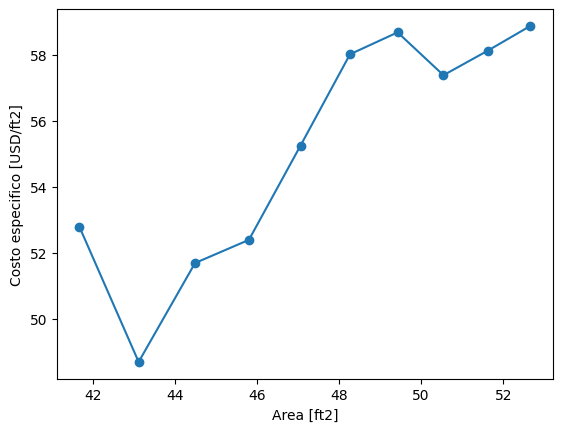

In [441]:
plt.plot(
    data['area'],
    data['costo_especifico'],
    marker='o'
)
plt.xlabel('Area [ft2]')
plt.ylabel('Costo especifico [USD/ft2]')
plt.grid(False)
plt.show()

In [442]:
# Define the power law function
def power_law(x, A, B):
    return A * (x ** B)

In [443]:
# Perform curve fitting to find A and B
params, covariance = curve_fit(
    power_law, 
    data['area'].to_numpy(),
    data["costo_especifico"].to_numpy()
)

In [444]:
# Extract the values of A and B
K, n = params

m = 1 + n
print("k =", K)
print("m =", m)
print("n =", n)

k = 3.2931097501375857
m = 1.7304197426067336
n = 0.7304197426067336


In [445]:
data['costo_intercambiador'] =  K * (data['area'] ** (m))
data.head()

,area,costo_total,temperatura,costo_especifico,costo_intercambiador
0,52.660691,3100,35,58.867438,3136.898961
1,51.620256,3000,36,58.116721,3030.428297
2,50.543195,2900,37,57.376665,2921.848997
3,49.426603,2900,38,58.672857,2811.055016
4,48.267190,2800,39,58.010421,2697.931345


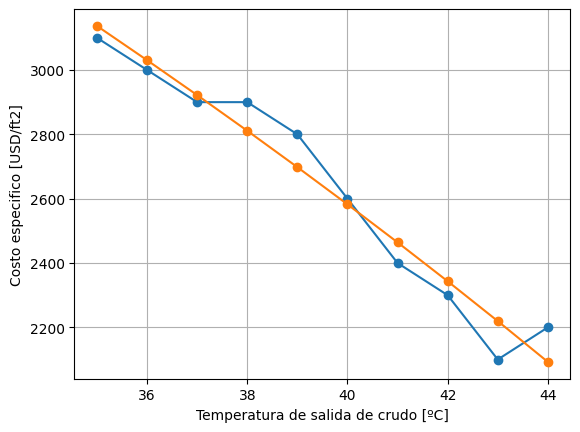

In [446]:
plt.plot(
    data['temperatura'],
    data['costo_total'],
    marker='o'
)
plt.plot(
    data['temperatura'],
    data['costo_intercambiador'],
    marker='o'
)
plt.xlabel('Temperatura de salida de leche [ºC]')
plt.ylabel('Costo especifico [USD/ft2]')
plt.grid()
plt.show()

## 5. Calculo  Refrigerador

$$ \dot{Q} = (\dot{m} *C_{p})_{leche} * (T_{entrada} -T_{salida})$$

In [452]:
calor_refrigerador = caudal_leche * cp_leche_kern * (temperatura_estimada_salida_leche - temperatura_salida_leche)
print(f"Calor transmitido al refrigerador {calor_refrigerador} W")

Calor transmitido al refrigerador 68250.0 W


In [460]:
calores_refrigeradores = caudal_leche * cp_leche_kern * (data['temperatura'] - temperatura_salida_leche)
print(f"Calor transmitido al refrigerador {calores_refrigeradores} W")
calores_refrigeradores_ingles = calores_refrigeradores * 3.41214 / 1e6
print(f"Calor transmitido al refrigerador {calores_refrigeradores_ingles} M Btu/h")

Calor transmitido al refrigerador 0    48750.0
1    50700.0
2    52650.0
3    54600.0
4    56550.0
5    58500.0
6    60450.0
7    62400.0
8    64350.0
9    66300.0
Name: temperatura, dtype: float64 W
Calor transmitido al refrigerador 0    0.166342
1    0.172995
2    0.179649
3    0.186303
4    0.192957
5    0.199610
6    0.206264
7    0.212918
8    0.219571
9    0.226225
Name: temperatura, dtype: float64 M Btu/h


In [462]:
data['costo_refrigerador'] = [
    48000,
    49300,
    50600,
    51900,
    53200,
    54500,
    55700,
    57000,
    58200,
    59400,
]

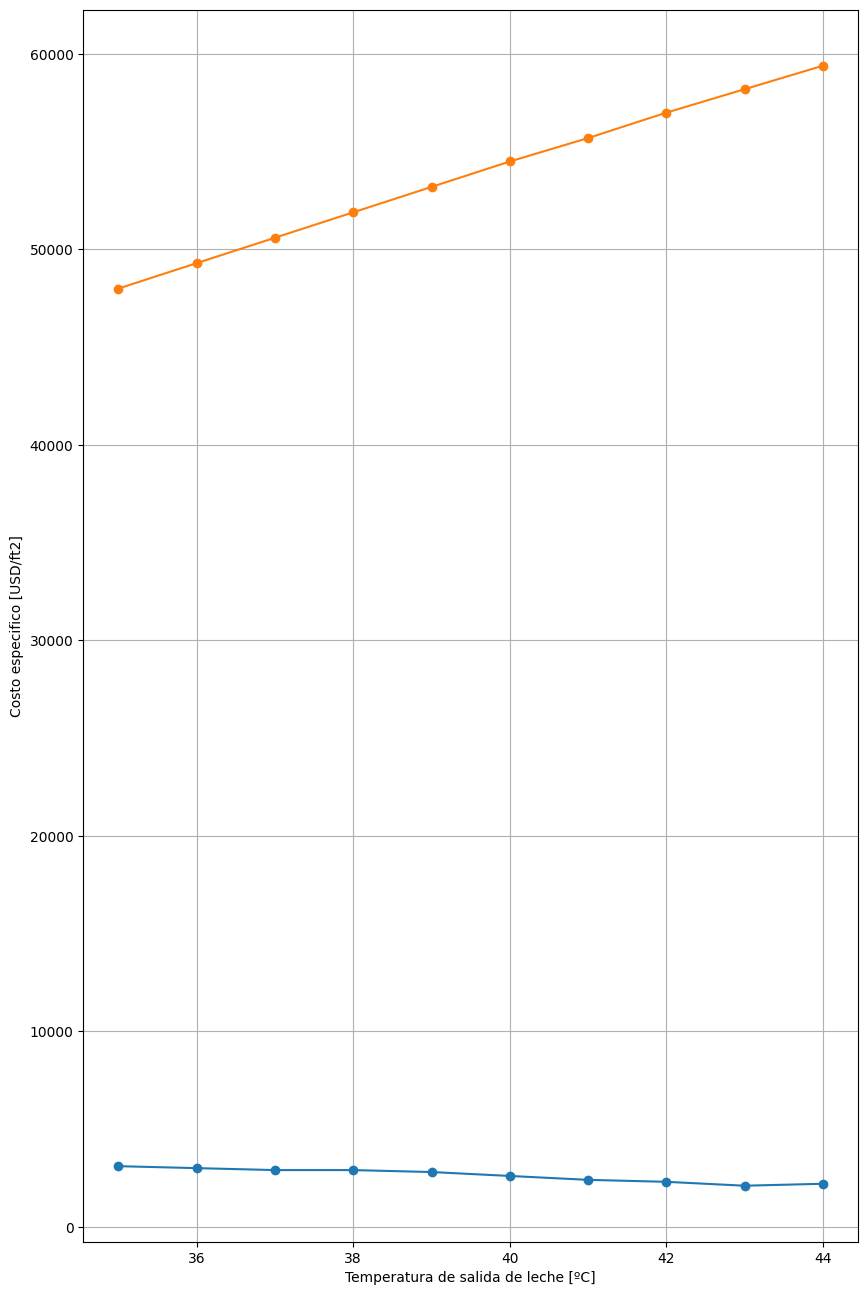

In [466]:

plt.figure(figsize=(10,16))
plt.plot(
    data['temperatura'],
    data['costo_total'],
    marker='o'
)
plt.plot(
    data['temperatura'],
    data['costo_refrigerador'],
    marker='o'
)
plt.xlabel('Temperatura de salida de leche [ºC]')
plt.ylabel('Costo especifico [USD/ft2]')
plt.grid()
plt.show()

# Referencias
- Abdulagatov, I.M., Abdulagatova, Z.Z., Grigor’ev, B.A. et al. Thermal Diffusivity, Heat Capacity, and Thermal Conductivity of Oil Reservoir Rock at High Temperatures. Int J Thermophys 42, 135 (2021). https://doi.org/10.1007/s10765-021-02878-x
- Seguros, V. (2021) Presión del Agua en Casa: Problemas habituales: Blog Verti, Verti Blog. Available at: https://blog.verti.es/hogar/presion-agua-casa/#:~:text=Lo%20habitual%20es%20que%20la,tengamos%20una%20presión%20u%20otra. (Accessed: 13 October 2023). 
- Bell, I.H. et al. (2014) ‘Pure and pseudo-pure fluid thermophysical property evaluation and the open-source Thermophysical Property Library coolprop’, Industrial &amp;amp; Engineering Chemistry Research, 53(6), pp. 2498–2508. doi:10.1021/ie4033999. 